In [2]:
import pandas as pd
import numpy as np
import zipfile 
import io
import os
import concurrent.futures
import time
import subprocess
import multiprocessing


# Data Loader

## Function to unzip folder

In [5]:
# Extract the zip and save in interim
data_folder = '../data'
zip_flight_data= data_folder + '/external/itineraries_csv.zip'

extract_directory = data_folder +'/interim'

# Read the zip file
with zipfile.ZipFile(zip_flight_data, 'r') as z:
    z.extractall(extract_directory)

print(f"Extracted {zip_flight_data} to {extract_directory}")



Extracted ../data/external/itineraries_csv.zip to ../data/interim


## Function to unzip CSV and save them as 1 per airport

In [8]:
# CHAMPION FILE EXTRACTOR
def process_folder(folder):    
    df_list = []
    files = os.listdir(f"../data/interim/itineraries_csv/{folder}")
    for file in files:
        file_path = f"../data/interim/itineraries_csv/{folder}/{file}"
        if file.endswith('.zip'):
            df=pd.read_csv(file_path, compression='zip')
            df_list.append(df)
    df_list = pd.concat(df_list)
    df_list.to_csv(f"../data/interim/{folder}.csv", index=False)
    print(f"Saved {folder}.csv")
root_dir = "../data/interim/itineraries_csv"
folders = [entry.name for entry in os.scandir(root_dir) if entry.is_dir()]

# Measure execution time
start_time = time.time()

# Limit the number of threads
max_threads = 4

# Use multiprocessing.Pool to run the folder processing function in parallel
with multiprocessing.Pool(processes=max_threads) as pool:
    pool.map(process_folder, folders)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.2f} seconds")

Saved IAD.csv
Saved JFK.csv
Saved PHL.csv
Saved ORD.csv
Saved OAK.csv
Saved DTW.csv
Saved DEN.csv
Saved LAX.csv
Saved CLT.csv
Saved EWR.csv
Saved MIA.csv
Saved BOS.csv
Saved LGA.csv
Saved ATL.csv
Saved SFO.csv
Saved DFW.csv
Execution time: 56.55 seconds


In [9]:
# Remove the processed folders to save storage space
subprocess.run(f"rm -rf ../data/interim/itineraries_csv", shell=True)
subprocess.run(f"rm -rf ../data/interim/__MACOSX", shell=True)
print("Removed folders")


Removed folders


# Read in airport CSV

In [3]:
df = pd.read_csv('../data/interim/ATL.csv')


In [4]:
df.describe( include='all') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874069 entries, 0 to 874068
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              874069 non-null  object 
 1   searchDate                         874069 non-null  object 
 2   flightDate                         874069 non-null  object 
 3   startingAirport                    874069 non-null  object 
 4   destinationAirport                 874069 non-null  object 
 5   travelDuration                     874069 non-null  object 
 6   isBasicEconomy                     874069 non-null  bool   
 7   isRefundable                       874069 non-null  bool   
 8   isNonStop                          874069 non-null  bool   
 9   totalFare                          874069 non-null  float64
 10  totalTravelDistance                769021 non-null  float64
 11  segmentsDepartureTimeEpochSeconds  8740

## Clean up data

In [5]:
# Function to clean and convert the data
def transform_data(df):

    # Convert date columns
    date_columns = ['searchDate', 'flightDate']
    df[date_columns] = df[date_columns].apply(pd.to_datetime)

    # Convert float to numeric
    float_columns = ['totalFare','totalTravelDistance']
    for col in float_columns:
        df[col] = pd.to_numeric(df[col],errors='coerce').astype('float32')

    # Drop rows
    df = df.dropna(subset=['segmentsEquipmentDescription','segmentsAirlineName'])
    return df

    


In [49]:
# Covert the segment data into new variables

airports= ['ATL','BOS','DEN','DFW','EWR','JFK','LAX','LGA','MIA','OAK','ORD','PHL','SFO']
# dictionary for the correct time offsets
time_offsets = {'ATL': '-04:00', 'BOS' : '-04:00' , 'DEN':'-06:00', 'DFW':'-05:00' ,'EWR':'-04:00',   'JFK': '-04:00','LAX': '-07:00', 'LGA': '-04:00', 'MIA': '-04:00', 'OAK': '-07:00', 'ORD': '-05:00', 'PHL': '-04:00', 'SFO': '-07:00'}

# Departure Hour Processing
def process_segments_DepartTime(df):
    # Split the departure time
    print("Shape before processing: ", df.shape)
    df["segmentsDepartureTimeRaw_hour"] = df["segmentsDepartureTimeRaw"].str.split("|").str[0]
    airportcode = df["startingAirport"][0]
    correct_time_offset = time_offsets[airportcode]

    # filter for departure time hour that has the correct time offset
    df = df[df["segmentsDepartureTimeRaw_hour"].str[-6:] == correct_time_offset]
    print("Shape after processing departure time: ", df.shape)

    # check date difference between the  segmentsDepartureTimeRaw_hour aNd flight date and eliminate any that dont match
    df["segmentsDepartureTimeRaw_hour"] = pd.to_datetime(
        df["segmentsDepartureTimeRaw_hour"]
    ).dt.tz_localize(None)
    df = df[(df["segmentsDepartureTimeRaw_hour"] - df["flightDate"]).dt.days == 0]
    print("Shape after filtering segment departure not the same as flight date: ", df.shape)

    # extract out the hour of the day
    df["segmentsDepartureTimeRaw_hour"] = df["segmentsDepartureTimeRaw_hour"].dt.hour.astype("int8")

    return df

# Cabin Class Encoding
cabin_class_encoding = {
    "coach": 1,
    "premium coach": 2,
    "business": 3,
    "first": 4,
}

def process_segments_CabinClass(df):
    # Split the Cabin class
    df["CabinCode"] = df["segmentsCabinCode"].str.split("\\|\\|")
    
    # apply cabin_class_encoding on the cabin class
    df["CabinCode"] = df["CabinCode"].apply(lambda x: [cabin_class_encoding.get(i, 0) for i in x])

    # get the average of the cabin class
    df["CabinCode"] = df["CabinCode"].apply(lambda x: np.mean(x))

    return df



In [50]:
df_segments = process_segments_CabinClass(transform_data(df))
print(df_segments['segmentsCabinCode'].unique())

/tmp/ipykernel_24847/1408719920.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CabinCode"] = df["segmentsCabinCode"].str.split("\\|\\|")
/tmp/ipykernel_24847/1408719920.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CabinCode"] = df["CabinCode"].apply(lambda x: [cabin_class_encoding.get(i, 0) for i in x])


['coach' 'coach||coach' 'coach||coach||coach' 'first'
 'coach||coach||coach||coach' 'premium coach' 'premium coach||coach'
 'coach||business' 'coach||premium coach' 'first||coach'
 'premium coach||premium coach' 'coach||premium coach||coach'
 'business||coach' 'coach||coach||coach||premium coach'
 'business||coach||coach' 'premium coach||coach||coach' 'coach||first'
 'first||first' 'first||coach||coach' 'business||business||coach'
 'first||coach||first' 'coach||first||coach' 'coach||coach||premium coach'
 'premium coach||premium coach||coach' 'coach||business||coach'
 'coach||business||business' 'coach||coach||business'
 'coach||first||first' 'coach||coach||first' 'coach||coach||coach||first']


/tmp/ipykernel_24847/1408719920.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CabinCode"] = df["CabinCode"].apply(lambda x: np.mean(x))


In [8]:
df_segments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 848468 entries, 0 to 874068
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              848468 non-null  object        
 1   searchDate                         848468 non-null  datetime64[ns]
 2   flightDate                         848468 non-null  datetime64[ns]
 3   startingAirport                    848468 non-null  object        
 4   destinationAirport                 848468 non-null  object        
 5   travelDuration                     848468 non-null  object        
 6   isBasicEconomy                     848468 non-null  bool          
 7   isRefundable                       848468 non-null  bool          
 8   isNonStop                          848468 non-null  bool          
 9   totalFare                          848468 non-null  float32       
 10  totalTravelDistance      

## Run some graphs to visualise the data

In [26]:
# function to plot the data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt




# Function to plot the data
def plot_data(df):
    # CHange width of all the plots
    plt.rcParams['figure.figsize'] = [10, 6]
    
    
    # # Plot the total fare distribution
    # sns.histplot(df['totalFare'], kde=True)
    # plt.title('Total Fare Distribution')
    # plt.show()

    # # Plot the total travel distance distribution
    # sns.histplot(df['totalTravelDistance'], kde=True)
    # plt.title('Total Travel Distance Distribution')
    # plt.show()

    # # #plot the segmentsAirlineCode, destinationAirport, segmentCabinCode in a facet grid
    # # sns.catplot(data=df, kind='count', x='segmentsAirlineCode', col='destinationAirport', row='segmentsCabinCode')
    # # plt.show()

    # # Plot the total fare vs total travel distance
    # sns.scatterplot(data=df, x='totalFare', y='totalTravelDistance')
    # plt.title('Total Fare vs Total Travel Distance')
    # plt.show()

    # # Function for cat plots
    # def catplot(x, df):
    #     g=sns.catplot(data=df, kind='violin', x=x, y='totalFare', height=5, aspect=4)
    #     return g
    
    # # Plot the destination city vs total fare
    # catplot('destinationAirport', df)
    # plt.title('Destination City vs Total Fare')
    # plt.show()

    # # Plot the departure time vs total fare
    # catplot('segmentsDepartureTimeRaw_hour', df)
    # plt.title('Departure Time vs Total Fare')
    # plt.show()

    # # Plot the distributions of total fare by isNonStop, isRefundable, and isBasicEconomy
    # catplot('isNonStop', df)
    # plt.title('Is Non Stop vs Total Fare')
    # plt.show()
    # catplot('isRefundable', df)
    # plt.title('Is Refundable vs Total Fare')
    # plt.show()
    # catplot('isBasicEconomy', df)
    # plt.title('Is Basic Economy vs Total Fare')
    # plt.show()

    # Plot the freuency of the segmentsCabinCode by bar plot and the average total fare
    plt.barh(df['segmentsCabinCode'].value_counts().index, df['segmentsCabinCode'].value_counts())






    






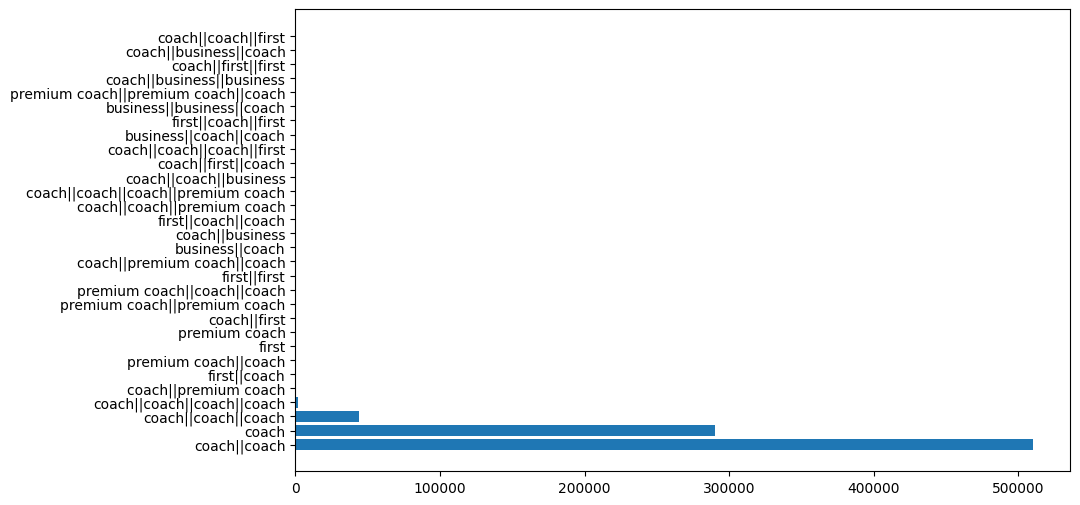

In [27]:
plot_data(df_segments)

In [29]:
# Tabulate the cabin code volume and average total fare
CabinAvgFare=df_segments.groupby('segmentsCabinCode')['totalFare'].agg(['count','mean'])
CabinAvgFare





,count,mean
segmentsCabinCode,,
business||business||coach,3,1409.166626
business||coach,29,1584.276245
business||coach||coach,6,1656.203247
coach,290405,286.470642
coach||business,21,1594.256104
coach||business||business,3,1861.299927
coach||business||coach,1,1487.099976
coach||coach,510391,363.338013
coach||coach||business,8,1028.723755


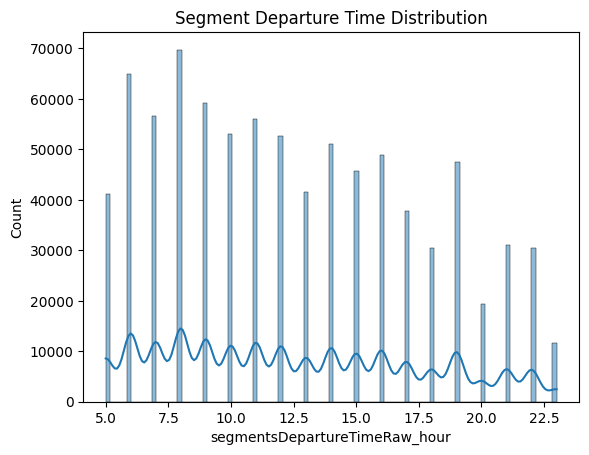

In [26]:
# visualise segment departure time
sns.histplot(df_segments['segmentsDepartureTimeRaw_hour'], kde=True)
plt.title('Segment Departure Time Distribution')
plt.show()


In [27]:
# Top desitations out of ATL
top_destinations = df_segments['destinationAirport'].value_counts()


## Merge into one master
